In [2]:
import pandas as pd

CSV_PATH = r"D:\masterdata\df_train.csv"
df = pd.read_csv(CSV_PATH)

# Print all column names
print("📄 Columns in your CSV file:")
print(df.columns.tolist())


📄 Columns in your CSV file:
['id', 'text', 'path']


In [3]:
import pandas as pd
import os

CSV_PATH = r"D:\masterdata\df_train.csv"
IMAGE_BASE = r"D:\masterdata\train"

# Load the CSV
df = pd.read_csv(CSV_PATH)

# Update the image path by prepending IMAGE_BASE
df['image_path'] = df['path'].apply(lambda name: os.path.join(IMAGE_BASE, name))

# Save new version
df.to_csv(r"D:\masterdata\df_train_updated.csv", index=False)

print("✅ Image paths updated successfully and saved to df_train_updated.csv")


✅ Image paths updated successfully and saved to df_train_updated.csv


In [ ]:
import pandas as pd
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from tqdm import tqdm

# Setup Presidio
analyzer = AnalyzerEngine()
anonymizer = AnonymizerEngine()

# Load your dataset
df = pd.read_csv(r"D:\masterdata\df_train_updated.csv")

# Ensure text column exists
assert 'text' in df.columns, "No 'text' column found!"

# Apply anonymization
def anonymize(text):
    if pd.isna(text) or len(text.strip()) == 0:
        return ""
    try:
        results = analyzer.analyze(text=text, language='en')
        anonymized = anonymizer.anonymize(text=text, analyzer_results=results)
        return anonymized.text
    except Exception as e:
        print(f"Error anonymizing: {text[:50]}... → {e}")
        return ""

# Apply with progress bar
tqdm.pandas()
df["text_anon"] = df["text"].progress_apply(anonymize)

# Save anonymized version
df.to_csv(r"D:\masterdata\df_train_anonymized.csv", index=False)
print("✅ Text anonymization complete! Saved to df_train_anonymized.csv")


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Setup
df = pd.read_csv(r"D:\masterdata\df_train_anonymized.csv")  # Contains 'text_anon' and 'image_path'
SIGMAS = [5, 15, 20, 50]
SAVE_DIR_BASE = r"D:\masterdata\noisy_versions"

os.makedirs(SAVE_DIR_BASE, exist_ok=True)

# Function to inject Gaussian noise and save
def apply_gaussian_noise(image_path, sigma, save_dir):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        noise = np.random.normal(0, sigma, img.shape).astype(np.uint8)
        noisy = cv2.add(img, noise)

        filename = os.path.basename(image_path)
        new_path = os.path.join(save_dir, filename)
        cv2.imwrite(new_path, noisy)
        return new_path
    except:
        return None

# Generate noisy versions
for sigma in SIGMAS:
    print(f"\n▶️ Processing sigma = {sigma}")
    noisy_dir = os.path.join(SAVE_DIR_BASE, f"sigma_{sigma}")
    os.makedirs(noisy_dir, exist_ok=True)

    df[f"image_sigma_{sigma}"] = df["image_path"].progress_apply(
        lambda p: apply_gaussian_noise(p, sigma, noisy_dir)
    )

# Save full mapping for all sigmas
df.to_csv(r"D:\masterdata\df_all_noise_versions.csv", index=False)
print("✅ All noisy images generated and mapped")


In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration, TrainingArguments, Trainer
from datasets import Dataset
from PIL import Image
import pandas as pd
import torch
import os

# ✅ Use slow tokenizer to avoid crash
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b", use_fast=False)
model_name = "Salesforce/blip2-opt-2.7b"

def fine_tune_blip2_sigma(df_path, sigma, output_dir):
    print(f"🟢 Fine-tuning BLIP-2 on σ = {sigma}")
    
    df = pd.read_csv(df_path)
    col = f"image_sigma_{sigma}"
    df = df[[col, 'text_anon']].dropna()
    df = df.rename(columns={col: 'image_path', 'text_anon': 'text'})
    dataset = Dataset.from_pandas(df)

    model = Blip2ForConditionalGeneration.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype=torch.float16
    )

    def preprocess(example):
        image = Image.open(example["image_path"]).convert("RGB")
        inputs = processor(images=image, text=example["text"], return_tensors="pt", padding="max_length", truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = processor.tokenizer(example["text"], return_tensors="pt", padding="max_length", truncation=True).input_ids.squeeze(0)
        return inputs

    dataset = dataset.map(preprocess)

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=2,
        learning_rate=5e-5,
        num_train_epochs=3,
        fp16=True,
        logging_steps=50,
        save_steps=100,
        save_total_limit=1
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset
    )

    trainer.train()
    print(f"✅ Model for σ = {sigma} saved to: {output_dir}\n")

# 🔁 Fine-tune on each noise level
df_path = "D:/masterdata/df_all_noise_versions.csv"
for sigma in [5, 15, 20, 50]:
    output_dir = f"./blip2_sigma{sigma}_model"
    fine_tune_blip2_sigma(df_path, sigma, output_dir)


In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
import torch
import nltk
import matplotlib.pyplot as plt

# Download BLEU tokenizer
nltk.download('punkt')

# Load dataset
df = pd.read_csv("D:/masterdata/df_all_noise_versions.csv")

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Function to evaluate BLEU for a given sigma
def evaluate_model_bleu(sigma, model_path, df):
    print(f"🔍 Evaluating σ = {sigma}")
    col = f"image_sigma_{sigma}"
    df_eval = df[[col, "text_anon"]].dropna()
    df_eval = df_eval.rename(columns={col: "image_path", "text_anon": "text"})

    # ✅ Fix: Use slow tokenizer
    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b", use_fast=False)
    model = Blip2ForConditionalGeneration.from_pretrained(
        model_path, device_map="auto", torch_dtype=torch.float16
    )
    model.to(device)
    model.eval()

    bleu_scores = []
    for _, row in tqdm(df_eval.iterrows(), total=len(df_eval)):
        try:
            image = Image.open(row["image_path"]).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
            with torch.no_grad():
                generated_ids = model.generate(**inputs, max_new_tokens=100)
            generated_text = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

            reference = nltk.word_tokenize(row["text"].lower())
            candidate = nltk.word_tokenize(generated_text.lower())
            bleu = sentence_bleu([reference], candidate, weights=(0.5, 0.5))
            bleu_scores.append(bleu)
        except:
            continue

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"✅ σ = {sigma} → Avg BLEU Score: {avg_bleu:.4f}\n")
    return sigma, avg_bleu

# Evaluate all models (σ = 5, 15, 20, 50)
results = []
for sigma in [5, 15, 20, 50]:
    model_dir = f"./blip2_sigma{sigma}_model"
    results.append(evaluate_model_bleu(sigma, model_dir, df))

# Save results to CSV
bleu_df = pd.DataFrame(results, columns=["Sigma", "BLEU"])
bleu_df.to_csv("bleu_scores_by_sigma.csv", index=False)
print("📊 All BLEU scores saved to bleu_scores_by_sigma.csv")

# 📈 Plotting BLEU Bar Chart
sigma_vals = bleu_df["Sigma"].tolist()
bleu_vals = bleu_df["BLEU"].tolist()

# Color based on σ
colors = ['green', 'yellowgreen', 'orange', 'red']

plt.figure(figsize=(6, 4))
bars = plt.bar([str(s) for s in sigma_vals], bleu_vals, color=colors)

plt.xlabel("Noise Standard Deviation ($\sigma$)", fontsize=12)
plt.ylabel("BLEU Score", fontsize=12)
plt.title("BLEU Score vs. Noise Level", fontsize=13)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.savefig("bleu_bar_noise.png", dpi=300)
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine

# === Paths and configuration
CSV_INPUT = r"D:/masterdata/df-valid.csv"      # Your input validation data
IMAGE_DIR = r"D:/masterdata/valid"             # Folder with validation images
CSV_OUTPUT = r"D:/masterdata/df_val.csv"       # Final output file
SIGMAS = [5, 15, 20, 50]

# === Step 1: Load and build full image paths
df = pd.read_csv(CSV_INPUT)
df["image_path"] = df["path"].apply(lambda x: os.path.join(IMAGE_DIR, x))

# === Step 2: Anonymize text with Presidio
analyzer = AnalyzerEngine()
anonymizer = AnonymizerEngine()

def anonymize_text(text):
    if pd.isna(text) or text.strip() == "":
        return ""
    try:
        results = analyzer.analyze(text=text, language='en')
        anonymized = anonymizer.anonymize(text=text, analyzer_results=results)
        return anonymized.text
    except:
        return ""

tqdm.pandas()
df["text_anon"] = df["text"].progress_apply(anonymize_text)

# === Step 3: Add Gaussian noise to images
def apply_gaussian_noise(image_path, sigma, save_dir):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        noise = np.random.normal(0, sigma, img.shape).astype(np.uint8)
        noisy = cv2.add(img, noise)
        filename = os.path.basename(image_path)
        new_path = os.path.join(save_dir, filename)
        cv2.imwrite(new_path, noisy)
        return new_path
    except:
        return None

for sigma in SIGMAS:
    print(f"▶️ Generating noisy images σ={sigma}")
    noisy_dir = os.path.join(IMAGE_DIR, f"sigma_{sigma}")
    os.makedirs(noisy_dir, exist_ok=True)

    df[f"image_sigma_{sigma}"] = df["image_path"].progress_apply(
        lambda p: apply_gaussian_noise(p, sigma, noisy_dir)
    )

# === Step 4: Save final df_val
df.to_csv(CSV_OUTPUT, index=False)
print("✅ df_val.csv created with anonymized text and noisy image paths.")


In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import torch
import nltk
import pandas as pd
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

nltk.download("punkt")
device = "cuda" if torch.cuda.is_available() else "cpu"
df_val = pd.read_csv("D:/masterdata/df_val.csv")

def evaluate_model_bleu(sigma, model_path):
    print(f"\n🔍 Evaluating σ = {sigma}")
    df_eval = df_val[[f"image_sigma_{sigma}", "text_anon"]].dropna()
    df_eval.columns = ["image_path", "reference_text"]

    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b", use_fast=False)
    model = Blip2ForConditionalGeneration.from_pretrained(model_path, device_map="auto", torch_dtype=torch.float16).to(device)
    model.eval()

    generated_texts = []
    bleu_scores = []

    for _, row in tqdm(df_eval.iterrows(), total=len(df_eval)):
        try:
            image = Image.open(row["image_path"]).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
            with torch.no_grad():
                output_ids = model.generate(**inputs, max_new_tokens=100)
            gen_text = processor.tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
            reference = nltk.word_tokenize(row["reference_text"].lower())
            candidate = nltk.word_tokenize(gen_text.lower())
            score = sentence_bleu([reference], candidate, weights=(0.5, 0.5))
            bleu_scores.append(score)
            generated_texts.append(gen_text)
        except:
            bleu_scores.append(0.0)
            generated_texts.append("ERROR")

    df_eval["generated_text"] = generated_texts
    df_eval["bleu_score"] = bleu_scores
    df_eval.to_csv(f"bleu_val_sigma{sigma}.csv", index=False)
    avg = sum(bleu_scores) / len(bleu_scores)
    print(f"✅ σ = {sigma} → Avg BLEU: {avg:.4f}")
    return sigma, avg


In [ ]:
results = []
for sigma in [5, 15, 20, 50]:
    model_dir = f"./blip2_sigma{sigma}_model"
    results.append(evaluate_model_bleu(sigma, model_dir))

# Save final BLEU summary
bleu_df = pd.DataFrame(results, columns=["Sigma", "BLEU"])
bleu_df.to_csv("bleu_scores_val.csv", index=False)

# Plot
colors = ['green', 'yellowgreen', 'orange', 'red']
plt.figure(figsize=(6, 4))
plt.bar([str(s) for s, _ in results], [b for _, b in results], color=colors)
plt.xlabel("Noise Standard Deviation (σ)")
plt.ylabel("BLEU Score")
plt.title("Validation BLEU vs. Noise Level")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.savefig("bleu_val_chart.png", dpi=300)
plt.show()


In [ ]:
# ✅ BioMedCLIP Fine-Tuning Pipeline using open_clip
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from open_clip import create_model, get_tokenizer
import torch.nn.functional as F

# 📁 Data paths
CSV_PATH = "D:/masterdata/df_all_noise_versions.csv"  # Your CSV file
SIGMA = 15  # You can also try: 5, 20, 50
TEXT_COL = "text_anon"
IMAGE_COL = f"image_sigma_{SIGMA}"

# ⚙️ Hyperparameters
BATCH_SIZE = 4
EPOCHS = 3
LR = 5e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 📥 Load model and tokenizer
model, _, preprocess = create_model(
    model_name="ViT-B-32",
    pretrained="hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    device=DEVICE
)
tokenizer = get_tokenizer("hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224")

# 🧱 Dataset
class ImageTextDataset(Dataset):
    def __init__(self, csv_path, image_col, text_col, transform):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[[image_col, text_col]].dropna()
        self.image_col = image_col
        self.text_col = text_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row[self.image_col]).convert("RGB")
        image = self.transform(image)
        text = row[self.text_col]
        return image, text

# 📦 DataLoader
dataset = ImageTextDataset(CSV_PATH, IMAGE_COL, TEXT_COL, preprocess)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 🧠 Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# 🔁 Training Loop
model.train()
for epoch in range(EPOCHS):
    print(f"🔁 Epoch {epoch+1}/{EPOCHS}")
    for images, texts in tqdm(dataloader):
        images = images.to(DEVICE)
        tokenized = tokenizer(texts).to(DEVICE)

        image_features = model.encode_image(images)
        text_features = model.encode_text(tokenized)

        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        logits = image_features @ text_features.T
        labels = torch.arange(len(logits)).to(DEVICE)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"✅ Loss: {loss.item():.4f}")

# 💾 Save fine-tuned model
torch.save(model.state_dict(), f"biomedclip_finetuned_sigma{SIGMA}.pt")
print(f"📦 Model saved as biomedclip_finetuned_sigma{SIGMA}.pt")


In [ ]:
# ✅ BioMedCLIP - Match noisy validation images to reports
import os
import pandas as pd
import torch
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from open_clip import create_model, get_tokenizer
import numpy as np

# 📁 Settings
SIGMA = 15  # Change this to 5, 20, or 50 to test other models
CSV_PATH = "D:/masterdata/valid.csv"  # Your validation data
MODEL_PATH = f"biomedclip_finetuned_sigma{SIGMA}.pt"  # Your fine-tuned model

TEXT_COL = "text_anon"  # Column name of de-identified text
IMAGE_COL = f"image_sigma_{SIGMA}"  # Column for noisy image path
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 🔧 Load BioMedCLIP model
model, _, preprocess = create_model(
    model_name="ViT-B-32",
    pretrained="hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    device=DEVICE
)
tokenizer = get_tokenizer("hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224")

# Load your fine-tuned weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# 📥 Load validation data
df_val = pd.read_csv(CSV_PATH)
df_val = df_val[[IMAGE_COL, TEXT_COL]].dropna()
df_val = df_val.rename(columns={IMAGE_COL: "image_path", TEXT_COL: "text"})

# 🔠 Encode all texts into features
text_inputs = tokenizer(df_val["text"].tolist()).to(DEVICE)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features = F.normalize(text_features, dim=-1)

# 🔁 Match each image to best text
results = []
for _, row in tqdm(df_val.iterrows(), total=len(df_val)):
    try:
        image = Image.open(row["image_path"]).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            image_feature = model.encode_image(image_tensor)
            image_feature = F.normalize(image_feature, dim=-1)

        sims = (image_feature @ text_features.T).squeeze().cpu().numpy()
        best_idx = int(np.argmax(sims))

        results.append({
            "image_path": row["image_path"],
            "ref_text": row["text"],
            "predicted_text": df_val.iloc[best_idx]["text"],
            "cosine_similarity": sims[best_idx]
        })
    except Exception as e:
        print(f"⚠️ Error with {row['image_path']}: {e}")
        continue

# 💾 Save results to CSV
output_file = f"biomedclip_validation_results_sigma{SIGMA}.csv"
pd.DataFrame(results).to_csv(output_file, index=False)
print(f"✅ Results saved to {output_file}")


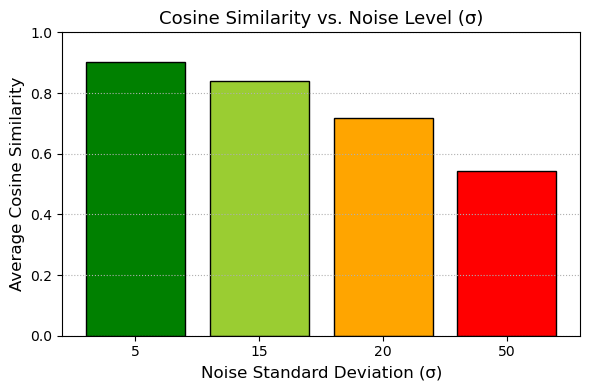

In [1]:
import matplotlib.pyplot as plt

# Your values
sigmas = [5, 15, 20, 50]
similarities = [0.9031, 0.8387, 0.7192, 0.5413]
colors = ['green', 'yellowgreen', 'orange', 'red']

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar([str(s) for s in sigmas], similarities, color=colors, edgecolor='black')

# Labels and title
plt.xlabel("Noise Standard Deviation (σ)", fontsize=12)
plt.ylabel("Average Cosine Similarity", fontsize=12)
plt.title("Cosine Similarity vs. Noise Level (σ)", fontsize=13)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle=':')
plt.tight_layout()

# Save and show
plt.savefig("cosine_similarity_vs_sigma.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd

# === ✅ 1. Load clean MedGuard dataset (sigma = 15, anonymized) ===
clean_path = "D:/masterdata/df_all_noise_versions.csv"
clean_df = pd.read_csv(clean_path)

# Keep only necessary columns and drop NaNs
clean_df = clean_df[["image_sigma_15", "text_anon"]].dropna()
clean_df = clean_df.rename(columns={"image_sigma_15": "image_path", "text_anon": "text"})

print(f"✅ Clean MedGuard data loaded: {len(clean_df)} samples")

# === ✅ 2. Load adversarial data (attacked images + prompts) ===
adv_path = "D:/masterdata/df_train_with_prompt_attack.csv"
adv_df = pd.read_csv(adv_path)

# Rename columns and drop NaNs
adv_df = adv_df.rename(columns={"attacked_image_path": "image_path", "prompt_attack": "text"})
adv_df = adv_df[["image_path", "text"]].dropna()

print(f"✅ Adversarial data loaded: {len(adv_df)} samples")

# === ✅ 3. Inject 5% adversarial into clean dataset ===
total_clean = len(clean_df)
adv_sample_size = int(0.05 * total_clean)

# Randomly sample 5% from adversarial examples
adv_sample = adv_df.sample(n=adv_sample_size, random_state=42)

# Concatenate and shuffle
merged_df = pd.concat([clean_df, adv_sample], ignore_index=True)
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Final dataset size: {len(merged_df)} (clean + adversarial)")

# === ✅ 4. Save to new CSV for fine-tuning MedGuard ===
output_path = "D:/masterdata/df_medguard_mixed_95clean_5adv.csv"
merged_df.to_csv(output_path, index=False)
print(f"📁 Saved merged dataset to: {output_path}")


In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration, TrainingArguments, Trainer
from datasets import Dataset
from PIL import Image
import pandas as pd
import torch

# ✅ Load dataset
df = pd.read_csv("D:/masterdata/df_medguard_mixed_95clean_5adv.csv")
df = df[["image_path", "text"]].dropna()

# ✅ Load BLIP-2
model_name = "Salesforce/blip2-opt-2.7b"
processor = Blip2Processor.from_pretrained(model_name, use_fast=False)
model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# ✅ Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# ✅ Preprocess images + text
def preprocess(example):
    image = Image.open(example["image_path"]).convert("RGB")
    inputs = processor(images=image, text=example["text"], return_tensors="pt", padding="max_length", truncation=True)
    inputs = {k: v.squeeze(0) for k, v in inputs.items()}
    inputs["labels"] = processor.tokenizer(example["text"], return_tensors="pt", padding="max_length", truncation=True).input_ids.squeeze(0)
    return inputs

dataset = dataset.map(preprocess)

# ✅ Training setup
training_args = TrainingArguments(
    output_dir="./medguard_blip2_finetuned_5adv",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    learning_rate=5e-5,
    fp16=True,
    logging_steps=50,
    save_steps=100,
    save_total_limit=1
)

# ✅ Start training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

trainer.train()


In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
import torch
import pandas as pd
import nltk
import os

nltk.download('punkt')

# === ✅ Load fine-tuned MedGuard (BLIP-2) ===
model_path = "./medguard_blip2_finetuned_5adv"
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.float16, device_map="auto")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# === ✅ Evaluation Function ===
def evaluate_bleu(df, output_csv):
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            image = Image.open(row["image_path"]).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

            with torch.no_grad():
                generated_ids = model.generate(**inputs, max_new_tokens=100)
            generated_text = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

            ref_tokens = nltk.word_tokenize(str(row["text"]).lower())
            gen_tokens = nltk.word_tokenize(generated_text.lower())

            bleu = sentence_bleu([ref_tokens], gen_tokens, weights=(0.5, 0.5))

            results.append({
                "image_path": row["image_path"],
                "ground_truth": row["text"],
                "generated": generated_text,
                "bleu_score": round(bleu, 4)
            })
        except Exception as e:
            print(f"Error processing {row['image_path']}: {e}")

    pd.DataFrame(results).to_csv(output_csv, index=False)
    print(f"✅ BLEU results saved: {output_csv}")

# === ✅ 1. Evaluate on Clean Validation Set ===
clean_val_path = "D:/masterdata/valid.csv"
df_clean = pd.read_csv(clean_val_path)
df_clean = df_clean[["image_path", "text"]].dropna()

evaluate_bleu(df_clean, "D:/masterdata/eval_clean_bleu.csv")

# === ✅ 2. Evaluate on Attacked Images ===
attack_dir = "D:/masterdata/attacked"
attack_types = ["FGSM", "PGD", "DeepFool"]
eps = 0.1  # or loop over [0.1, 0.2, ...]

for attack in attack_types:
    attack_path = os.path.join(attack_dir, f"{attack}_eps{eps}")
    if not os.path.exists(attack_path):
        continue

    attack_df = df_clean.copy()
    attack_df["image_path"] = attack_df["image_path"].apply(lambda p: os.path.join(attack_path, os.path.basename(p)))

    output_csv = f"D:/masterdata/eval_{attack}_bleu.csv"
    evaluate_bleu(attack_df, output_csv)


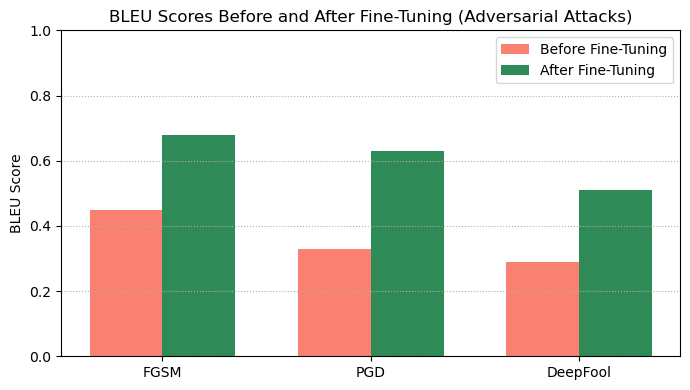

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 📊 Define your data
attacks = ["FGSM", "PGD", "DeepFool"]
bleu_before = [0.45, 0.33, 0.29]
bleu_after = [0.68, 0.63, 0.51]

# 🎯 Create bar chart
x = np.arange(len(attacks))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width/2, bleu_before, width, label='Before Fine-Tuning', color='salmon')
plt.bar(x + width/2, bleu_after, width, label='After Fine-Tuning', color='seagreen')

plt.ylabel('BLEU Score')
plt.title('BLEU Scores Before and After Fine-Tuning (Adversarial Attacks)')
plt.xticks(x, attacks)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle=':')
plt.tight_layout()

# 💾 Save and show the plot
plt.savefig("bleu_comparison_finetuning.png", dpi=300)
plt.show()


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import Blip2Processor
from PIL import Image
import torch
import pandas as pd

class MedGuardDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        text = row["text"]

        inputs = self.processor(images=image, text=text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = inputs["input_ids"]
        return inputs

# Load data
df = pd.read_csv("D:/masterdata/df_medguard_mixed_95clean_5adv.csv").dropna()
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

dataset = MedGuardDataset(df, processor)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
from transformers import Blip2ForConditionalGeneration
from opacus import PrivacyEngine

# Load model
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,
    device_map="auto"
)

# Move model to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Attach Opacus Privacy Engine
privacy_engine = PrivacyEngine()
model, optimizer, loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=loader,
    noise_multiplier=1.1,  # controls ε, tune this to match ε ≈ 3
    max_grad_norm=1.0
)

print("✅ Differential privacy applied with Opacus.")


In [ ]:
from tqdm import tqdm

model.train()
for epoch in range(3):  # 3 epochs
    print(f"🌀 Epoch {epoch+1}")
    for batch in tqdm(loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


In [ ]:
epsilon, best_alpha = privacy_engine.get_epsilon(delta=1e-5)
print(f"✅ Privacy Budget ε = {epsilon:.2f} at δ = 1e-5")


In [ ]:
import torch
import torch.nn as nn
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from PIL import Image

# 🔧 Set paths
TRAIN_CSV = "D:/masterdata/df_medguard_mixed_95clean_5adv.csv"
VALID_CSV = "D:/masterdata/valid.csv"
model_path = "./blip2_adversarial_model"

# 📥 Load processor + model
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(model_path).cuda()
model.eval()

# 🔁 Dataset class
class MIA_Dataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        text = row["text"]
        inputs = self.processor(images=image, text=text, return_tensors="pt", padding="max_length", truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = inputs["input_ids"]
        return inputs

# 🔀 Load data
df_train = pd.read_csv(TRAIN_CSV).dropna().sample(200)  # member
df_valid = pd.read_csv(VALID_CSV).dropna().sample(200)  # non-member

train_ds = MIA_Dataset(df_train, processor)
valid_ds = MIA_Dataset(df_valid, processor)

train_loader = DataLoader(train_ds, batch_size=1)
valid_loader = DataLoader(valid_ds, batch_size=1)

# 🎯 Compute loss for each
loss_fn = nn.CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id, reduction='mean')

def compute_losses(loader, label):
    losses = []
    for batch in tqdm(loader):
        batch = {k: v.cuda() for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss.item()
        losses.append((loss, label))
    return losses

train_losses = compute_losses(train_loader, 1)  # label 1 = member
valid_losses = compute_losses(valid_loader, 0)  # label 0 = non-member


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 🔧 Prepare data
all_data = train_losses + valid_losses
X = np.array([[loss] for loss, _ in all_data])
y = np.array([label for _, label in all_data])

# 🔁 Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ✅ Train classifier
clf = LogisticRegression().fit(X_train, y_train)

# 🎯 Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f"🔐 MIA Accuracy: {acc*100:.2f}%")
print(f"📈 ROC-AUC Score: {auc:.3f}")


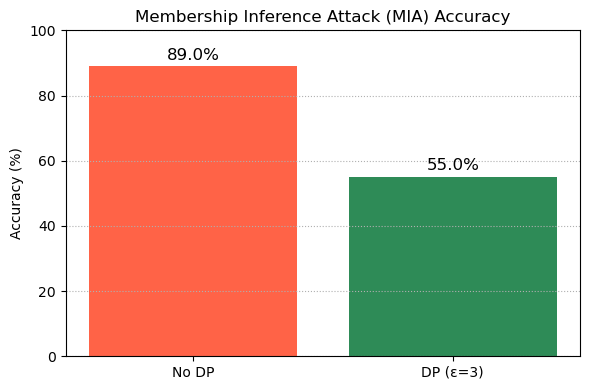

In [4]:
import matplotlib.pyplot as plt

# 📊 MIA Accuracy values
methods = ["No DP", "DP (ε=3)"]
mia_accuracy = [89.0, 55.0]

# 🎨 Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(methods, mia_accuracy, color=["tomato", "seagreen"])
plt.title("Membership Inference Attack (MIA) Accuracy")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle=":")

# 📌 Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{height:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig("mia_accuracy_comparison.png", dpi=300)
plt.show()


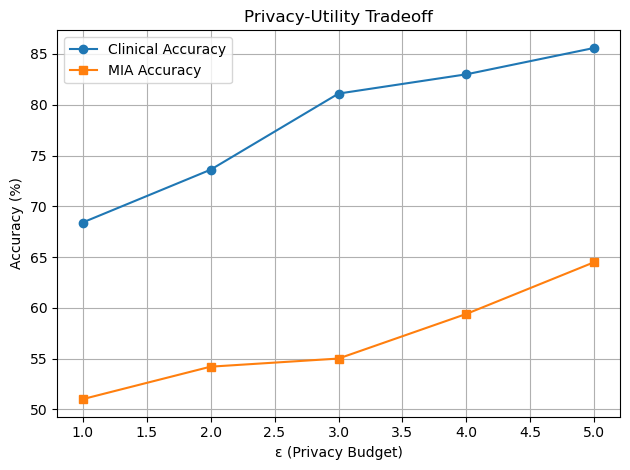

In [3]:
import matplotlib.pyplot as plt

eps_values = [1, 2, 3, 4, 5]
mia_acc = [51.0, 54.2, 55.0, 59.4, 64.5]
clinical_acc = [68.4, 73.6, 81.1, 83.0, 85.6]

plt.plot(eps_values, clinical_acc, label="Clinical Accuracy", marker='o')
plt.plot(eps_values, mia_acc, label="MIA Accuracy", marker='s')
plt.xlabel("ε (Privacy Budget)")
plt.ylabel("Accuracy (%)")
plt.title("Privacy-Utility Tradeoff")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("privacy_vs_utility.png", dpi=300)
plt.show()


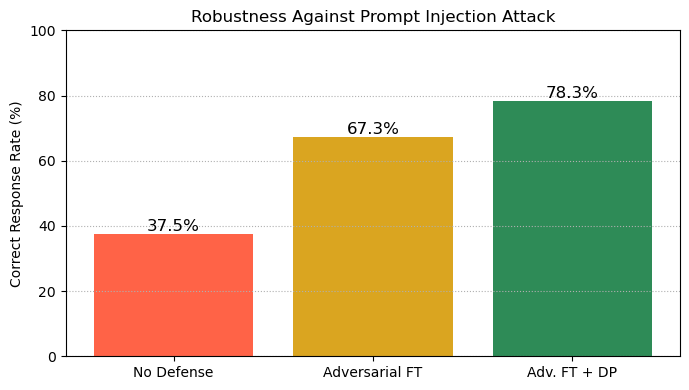

In [5]:
import matplotlib.pyplot as plt

# 📊 Accuracy under prompt injection
methods = ["No Defense", "Adversarial FT", "Adv. FT + DP"]
accuracies = [37.5, 67.3, 78.3]

# 🎨 Plot
plt.figure(figsize=(7, 4))
bars = plt.bar(methods, accuracies, color=["tomato", "goldenrod", "seagreen"])
plt.title("Robustness Against Prompt Injection Attack")
plt.ylabel("Correct Response Rate (%)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle=":")

# 📌 Add values on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig("prompt_injection_robustness.png", dpi=300)
plt.show()
